# Segmenting and Clustering Neighborhoods in Toronto

_Import packages_

In [172]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

_URL, Request and Response_

In [173]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
r = requests.Session()
response= r.get(url, timeout=10)
response

<Response [200]>

_Wrangling HTML With BeautifulSoup_

In [174]:
soup = BeautifulSoup(response.content, 'html.parser')

_Title of HTML Table_

In [175]:
title=soup.title.string
title

'List of postal codes of Canada: M - Wikipedia'

_Select table_

In [176]:
Canada_table=soup.find('table',{'class':'wikitable sortable'})
for row in Canada_table.findAll("tr"):
    cells = row.findAll('td')
print('the number of columns is:', len(cells)) #number of cols

rows = Canada_table.findAll("tr")
print('the number of rows is:', len(rows)) #number of rows

the number of columns is: 3
the number of rows is: 181


_Get header_

In [177]:
header = [th.text.rstrip() for th in rows[0].find_all('th')]
print(header)

['Postal Code', 'Borough', 'Neighbourhood']


_Get tabular data_

In [178]:
first_data_raw=1

lst_data_raw=[]
for row in rows[first_data_raw:]:
    tds = row.select('td')
    code = tds[0]
    data = [code.text.rstrip()]
    data.extend([d.text.rstrip() for d in tds[1:]])
    lst_data_raw.append(data)
#print(lst_data_raw)

_Create dictionary_

In [179]:
datax = list(zip(*lst_data_raw))
dat = dict(zip(header, datax))

_Create data frame_

In [180]:
df = pd.DataFrame(dat)

_Clean data frame: drop rows where 'Borough' is not assigned_

In [181]:
df1=df.drop(df.loc[df['Borough']=='Not assigned'].index)

_Clean data frame: assign value in 'Borough' column if 'Neighbourhood' is not assigned_

In [182]:
df1['Neighbourhood'] = df1.apply(lambda x: x['Borough'] if x['Neighbourhood']=='Not assigned' else x['Neighbourhood'], axis=1)

_Check cleaned data frame shape_

In [183]:
df1.shape

(103, 3)

# Latitude and Longitude data

In [184]:
df1.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


_Import latitude and longitude data_

In [185]:
import io

url_gps= 'https://cocl.us/Geospatial_data'
j=requests.get(url_gps).content
df_gps= pd.read_csv(io.StringIO(j.decode('utf-8')))

In [186]:
df_gps.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


_Merge dataframes df1 and df_gps using 'Postal Code' column (inner join)_

In [187]:
new_df=pd.merge(df1,df_gps,on='Postal Code',how='inner')

In [188]:
new_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [189]:
new_df.shape

(103, 5)

# Toronto map

_import libraries_

In [190]:
import numpy as np
import json 
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 

_Get the latitude and longitude values of Toronto._

In [191]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


_Create a map of Toronto with neighborhoods superimposed on top **(only neighborhoods containing 'Toronto')**_

In [192]:
df_toronto=new_df[new_df['Borough'].str.contains('Toronto', regex=False, case=False, na=False)]

In [193]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

_Define Foursquare Credentials and Version_

In [216]:
CLIENT_ID = '--------------' 
CLIENT_SECRET = '----------------' 
VERSION = '20180605' 
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: --------------
CLIENT_SECRET:----------------


_reset index_

In [195]:
df_toronto.reset_index(drop=True, inplace=True)

In [196]:
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


_Function to get nearby venues_

In [197]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
 
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

_Toronto venues dataframe_

In [198]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude'])

In [199]:
print(toronto_venues.shape)

(1618, 7)


_Number of venues in Toronto df, grouped by neighborhood_

In [200]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,64,64,64,64,64,64
Christie,16,16,16,16,16,16
Church and Wellesley,80,80,80,80,80,80
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


In [201]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


_New data frame with the different venue categories as columns, and rows=neighborhoods_

In [202]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.shape

(1618, 235)

_New df, where rows are grouped by neighborhood, and each column is the mean of the frequency of occurrence of each category_

In [203]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

toronto_grouped.shape

(39, 235)

_Top 5 most common venues in each neighborhood_ (just to check)

In [204]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
          venue  freq
0   Coffee Shop  0.09
1  Cocktail Bar  0.05
2      Beer Bar  0.03
3      Pharmacy  0.03
4        Bakery  0.03


----Brockton, Parkdale Village, Exhibition Place----
                    venue  freq
0                    Café  0.13
1             Coffee Shop  0.09
2          Breakfast Spot  0.09
3                     Gym  0.04
4  Furniture / Home Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0    Light Rail Station  0.12
1           Yoga Studio  0.06
2         Auto Workshop  0.06
3  Gym / Fitness Center  0.06
4         Garden Center  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.19
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3  Sculpture Garden  0.06
4   Harbor / Marina  0.06


----Central Bay Street----
                venue  f

_Function_

In [205]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

_new dataframe with the top 10 venues for each neighborhood (sorted in descending order)_

In [217]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Farmers Market,Pharmacy,Cheese Shop,Bakery,Restaurant,Seafood Restaurant,Butcher
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Grocery Store,Bakery,Bar,Italian Restaurant,Restaurant,Climbing Gym,Burrito Place
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Yoga Studio,Auto Workshop,Gym / Fitness Center,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Pizza Place
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Sculpture Garden,Plane,Rental Car Location,Boat or Ferry,Bar,Airport Gate
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint,Salad Place,Bubble Tea Shop,Thai Restaurant,Ramen Restaurant,Portuguese Restaurant


_k selection for k-means clustering, using Elbow method_

In [207]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

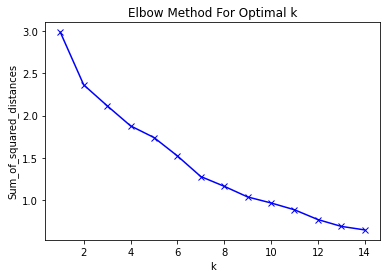

In [208]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

_**I assume that the elbow is at k=2**_

---------------------
_k-means clustering of neighborhoods_

In [209]:
# set number of clusters
kclusters = 2

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

_a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood_

In [210]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with df_toronto to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() 

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Café,Park,Bakery,Pub,Theater,Breakfast Spot,Electronics Store,Spa,Beer Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Diner,Smoothie Shop,Italian Restaurant,Beer Bar,Sandwich Place,Burrito Place,Discount Store
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Hotel,Middle Eastern Restaurant,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Fast Food Restaurant,Diner
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,American Restaurant,Cosmetics Shop,Cocktail Bar,Department Store,Farmers Market,Gastropub,Restaurant,Creperie
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pub,Trail,Health Food Store,Asian Restaurant,Wine Bar,Distribution Center,Department Store,Dessert Shop,Diner,Discount Store


_Cluster visualization_

In [212]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

_Cluster Analysis_

In [213]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Café,Park,Bakery,Pub,Theater,Breakfast Spot,Electronics Store,Spa,Beer Store
1,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Diner,Smoothie Shop,Italian Restaurant,Beer Bar,Sandwich Place,Burrito Place,Discount Store
2,Downtown Toronto,0,Coffee Shop,Clothing Store,Café,Hotel,Middle Eastern Restaurant,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Fast Food Restaurant,Diner
3,Downtown Toronto,0,Coffee Shop,Café,American Restaurant,Cosmetics Shop,Cocktail Bar,Department Store,Farmers Market,Gastropub,Restaurant,Creperie
4,East Toronto,0,Pub,Trail,Health Food Store,Asian Restaurant,Wine Bar,Distribution Center,Department Store,Dessert Shop,Diner,Discount Store
5,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Beer Bar,Farmers Market,Pharmacy,Cheese Shop,Bakery,Restaurant,Seafood Restaurant,Butcher
6,Downtown Toronto,0,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint,Salad Place,Bubble Tea Shop,Thai Restaurant,Ramen Restaurant,Portuguese Restaurant
7,Downtown Toronto,0,Grocery Store,Café,Park,Athletics & Sports,Italian Restaurant,Restaurant,Baby Store,Candy Store,Coffee Shop,Nightclub
8,Downtown Toronto,0,Coffee Shop,Café,Hotel,Restaurant,Gym,Deli / Bodega,Thai Restaurant,American Restaurant,Steakhouse,Lounge
9,West Toronto,0,Pharmacy,Bakery,Grocery Store,Supermarket,Middle Eastern Restaurant,Music Venue,Pizza Place,Pool,Portuguese Restaurant,Café


In [214]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,1,Park,Swim School,Construction & Landscaping,Bus Line,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant
29,Central Toronto,1,Park,Gym,Deli / Bodega,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run
33,Downtown Toronto,1,Park,Trail,Playground,Dance Studio,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run


## Toronto neighborhoods can be diveded into two clusters ##
### It seems logical to name those clusters "_parks_" and "_coffe shops_"